In [9]:
import matplotlib.pyplot as plt

from data.LSA_Dataset import LSA_Dataset
from data.transforms import get_frames_reduction_transform, get_roi_selector_transform

In [10]:
root = '/mnt/data/datasets/cn_sordos_db/data/cuts'
max_frames = 75

dataset = LSA_Dataset(
    root,
    frame_transform = get_roi_selector_transform(128,128),
    video_transform = get_frames_reduction_transform(max_frames),
    keypoints_transform = get_frames_reduction_transform(max_frames)
    )

In [11]:
import random

i = random.randint(0, dataset.__len__())
sample = dataset.__getitem__(i)

['utilizar', 'la', 'menor', 'cantidad', 'posible', 'los', 'artículos', 'de', 'un', 'solo', 'uso']
[F, C, H, W] torch.Size([75, 3, 128, 128])


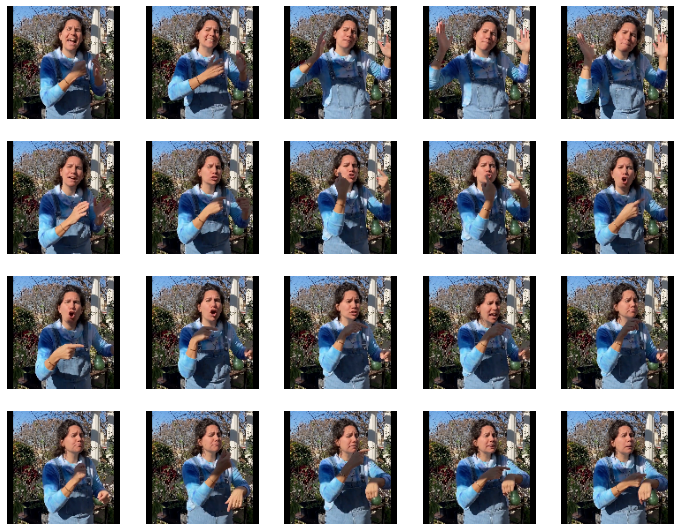

In [12]:
print(sample[3].tokens)
clip = sample[1]
print("[F, C, H, W]", clip.size())
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    iclip = clip[i, ...].permute(1,2,0)
    plt.imshow(iclip)
    plt.axis("off")

In [13]:
print(sample[3].tokens)
keys = sample[2]
print(len(keys))
print(keys[0]['keypoints'])


['utilizar', 'la', 'menor', 'cantidad', 'posible', 'los', 'artículos', 'de', 'un', 'solo', 'uso']
75
[1011.7110595703125, 301.1724548339844, 0.34537240862846375, 1052.7174072265625, 272.56585693359375, 0.23215073347091675, 970.7176513671875, 259.89410400390625, 0.37857919931411743, 1091.114013671875, 335.92425537109375, 0.18226595222949982, 888.64013671875, 317.37579345703125, 0.401947557926178, 1157.1324462890625, 549.096435546875, 0.0873759314417839, 785.3384399414062, 544.658203125, 0.7965829372406006, 1261.0634765625, 848.0733642578125, 0.8287279605865479, 775.3406982421875, 904.8792724609375, 0.852863609790802, 1217.31396484375, 682.2058715820312, 0.46248599886894226, 1013.3534545898438, 675.2535400390625, 0.6572070717811584, 1106.13232421875, 1060.643798828125, 0.405366450548172, 869.974365234375, 1070.7548828125, 0.40885984897613525, 1203.2674560546875, 750.3388671875, 6.229207087926625e-07, 822.2962036132812, 1013.1425170898438, 5.566828349401476e-06, 1166.0096435546875, 652.43

In [ ]:
loader = DataLoader(dataset, batch_size=12)
data: Dict[str, Any] = {'path': [], 'clip': [], 'keypoints': [], 'label': []}
for batch in loader:
    for i in range(len(batch['path'])):
        data['path'].append(batch['path'][i])
        data['clip'].append(batch['clip'][i].size())
        #data['keypoints'].append(batch['end'][i])
        data['label'].append(batch['label'][i])
print(data)